# Tutorial analisi spettri e correlazioni

## Introduzione
Questo quaderno si inserisce nel materiale didattico che verrà fornito agli studenti del secondo modulo del corso di laboratorio di fisica 3A (per gli amici Labo 4).

Ho scelto di ripercorrere l'analisi di un esperimento obbligatorio lo scorso anno ma facoltativo quest'anno poiché al suo interno contiene tutte le tecniche da utilizzare nelle altre attività ma al tempo stesso non fornisce un template già pronto da utilizzare come una black box per analizzare in automatico i dati raccolti.

Nel caso durante il corso nascessero esigenze particolari riguardo a qualche dubbio nell'effettuare una certa procedura, oppure vi trovaste a dover lavorare con dati in formati strani, esattamente come durante lo scorso semestre, potete contattarmi e d'accordo con gli altri tutor e con i docenti, vedrò di venirvi incontro nel miglior modo possibile. La mia mail è [scarsi@studenti.uninsubria.it](mailto:scarsi@studenti.uninsubria.it)

## Scopo
In questo quaderno verranno presentati alcuni spunti necessari per poter costruire istogrammi relativi a spettri, fittarne i picchi e costruire istogrammi bidimensionali per studiare le correlazioni.

Il dataset utilizzato è quello relativo all'analisi della *lifetime del $^{57}$Co* (che quest'anno risulta essere una attività a scelta), ma le medesime tecniche si applicano ad un generico contesto in cui si hanno dei rivelatori da cui, sotto certe condizioni di trigger, viene estratto il massimo della waveform e si deve valutare la distribuzione dei massimi (come per esempio nel contesto della spettroscopia gamma, di cui vedremo un assaggio nell'esercitazione).

## Strumenti
L'analisi viene effettuata utilizzando `Python 3` ed in particolare  moduli `numpy`, `matplotlib`  e `scipy` per la gestione e la visualizzazione di dati numerici.

## Setup sperimentale e contesto
Il setup sperimentale è costituito da due tubi fotomoltiplicatori (PMT) connessi ad una catena elettronica di amplificazione e shaping. Ogni qualvolta almeno uno dei due PMT è sopra una soglia prestabilita, vengono acquisiti i *massimi delle forme d'onda* di ciascun canale.

Lo stato eccitato del $^{57}$Fe può decadere o emettendo un fotone da 136 keV (parte sx dello schema) che può venir rivelato da un PMT oppure emettendo in successione due fotoni da 122 keV e 14keV, che possono venir rivelati ciascuno da uno dei due PMT.

<img src='img1.jpg' width="600" height="600"> </img>
<img src='img2.jpg' width="600" height="600"> </img>


## Formato dei dati
I dati sono dei files di testo (in formato ASCII): ogni riga corrisponde ad un evento (ovvero ogni volta che almeno uno dei due PMT ha avuto valore sopra soglia), mentre ogni colonna contiene una certa quantità. Aprendo un file, esso ha la forma

```
...
00000022 1556869569 00117 00479 02536 00924
00000023 1556869569 09368 00732 03898 00972
00000024 1556869569 00008 00054 11311 01006
00000025 1556869569 00002 00051 10155 01002
00000026 1556869569 00178 00847 15232 00840
00000027 1556869569 00010 00083 15228 00914
00000028 1556869569 00000 00000 00003 00052
00000029 1556869569 00029 00773 15227 00876
00000030 1556869569 00763 00208 00002 00053
00000031 1556869569 00872 00208 00002 00057
00000032 1556869569 00081 00851 08307 01006
...
```


dove la prima colonna rappresenta il numero dell'evento, la seconda colonna il [tempo unix](https://it.wikipedia.org/wiki/Tempo_(Unix)) (ovvero il numero di secondi trascorsi dalla mezzanotte del 1° Gennaio 1970) mentre le successive colonne rappresentano il massimo del segnale e il relativo tempo rispetto al trigger per ciascuno dei due PMT.


## Analisi dei dati
Iniziamo caricando (`import`) i moduli che verranno utulizzati durante l'analisi e definendo un alias per comodità nel richiamarli.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
from scipy.optimize import curve_fit


# Questa variabile può essere comoda per decidere se salvare o meno i plot che si vanno a creare
Export = False

## Load dei dati

Carichiamo [i dati](https://scarsi.web.cern.ch/INSULAB/LAB4/run020006.dat) utilizzando il metodo `np.loadtxt`. Il carattere "_", pur essendo un nome lecito per una variabile, viene convenzionalmente utilizzato per indicare una variabile di nessuna importanza. Infatti per caricare una matrice con N colonne ed utilizzare l'opzione `unpack=True` (che permette di memorizzare ciascuna colonna in un diverso vettore) è necessario passare tante variabili quante sono le colonne, indipendentemente dal fatto che alcune non sono interessanti.

Inoltre poichè il tempo è espresso in unità di tick del digitizer ed il digitizer campiona con una frequenza di 500MHz, si ha che 1 tick = 2 ns

In [2]:
_, time, ADC1, time1, ADC2, time2 = np.loadtxt(r".\run020006.dat", unpack=True)#, dtype=np.int32)

#nev, time, ADC1, time1, ADC2, time2 = np.loadtxt(r".\run020006.dat", unpack=True)#, dtype=np.int32)
#dati = np.loadtxt(r".\run020006.dat")

# Il tempo è in tick: 1tick=2ns ==> Converto il tempo in ns
time1 *= 2
time2 *= 2

Vediamo che si tratta di un dataset con quasi 8 milioni di eventi: è naturale che ci voglia qualche secondo a caricarli in memoria

In [3]:
print(ADC1.shape)
print(ADC1)

(7748980,)
[ 0.  0.  0. ...  3. 33. 85.]


## Visualizzazione dei dati
La prima cosa da fare quando si hanno dei dati è sicuramente guardarli. Uno potrebbe essere tentato di costruire un plot ampiezza vs tempo

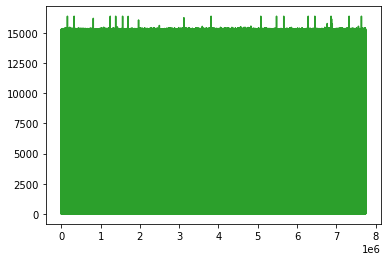

In [4]:
plt.plot(ADC1, c = "tab:green")
plt.show()

Ma purtroppo non si vede un granchè. Possiamo provare a plottare singoli punti non uniti da linee, eventualmente con marker più picolo

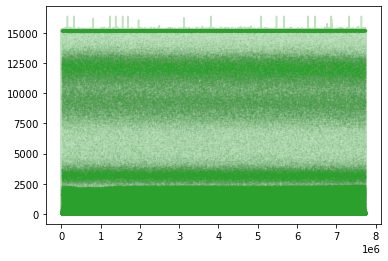

In [5]:
plt.plot(ADC1, c = "tab:green", marker='.', alpha=0.3, ms = .1)
plt.show()

Il problema risiede nel fatto che questi dati non sono da guardare in questo modo

## Costruzione degli spettri
A noi infatti interessa studiare la distribuzione dei massimi, sapere in un certo intervallo di valori quanti eventi sono stati registrati: dobbiamo costruire un **istogramma**

`Matplotlib` mette a disposizione il metodo `hist` che permette di effettuare l'istogramma di un vettore

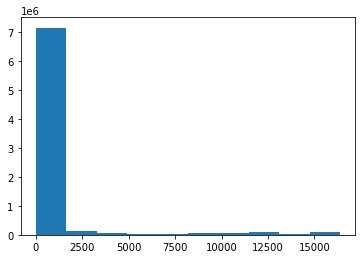

In [6]:
plt.hist(ADC1)
plt.show()

Da questo istogramma si vede poco e nulla. Proviamo ad aumentare il numero di bin

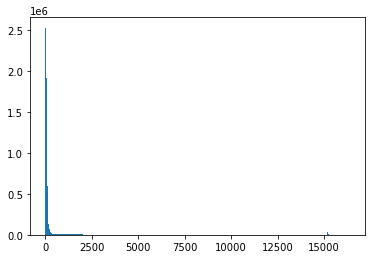

In [7]:
plt.hist(ADC1, bins = 500)
plt.show()

C'è ancora un po' da lavorare per ottenere lo spettro. Vi segnalo che anche `numpy` consente di effettuare istogrammi. Personalmente preferisco mantenere distinta la parte in cui vado a costruire l'istogramma e la parte in cui vado a plottare l'istogramma costruito, pertanto di seguito tutti gli istogrammi saranno creati con il metodo `np.histogram`.

Notiamo come i due metodi ([matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) e [numpy](https://numpy.org/doc/stable/reference/generated/numpy.histogram.html)) accettino gli stessi argomenti, ad eccezione dei parametri relativi alla grafica. Infatti il metodo di matplotlib va a richiamare proprio quello di numpy.




## Istogrammi 1D e spettri
Il metodo `np.histogram` accetta come argomento obbligatorio il dataset da istogrammare. Possiamo poi specificargli alcuni parametri opzionali, come per esempio il *numero di bin* o il *range*. Gli argomenti che ritorna invece sono il numero di eventi per ciascun bin e il bordo dei bin.

Il secondo vettore ha un elemento in più del primo e, per ottenere le coordinate $xy$ da plottare, è necessario sfasare tutti i punti, ad eccezione dell'ultimo, di mezzo bin.

Quando devo disegnare più curve in uno stesso plot con impostazioni analoghe, per comodità definisco un dizionario che le contiene e le passo alla funzione `plt.plot` effettuando l'*unpacking dei dizionari* mediante il doppio asterisco.

Per poter disegnare un istogramma con il metodo `plt.plot` è necessario specificare l'opzione `drawstyle` (o la sua abbreviazione `ds`) a `steps-mid`, che indica di tracciare il grafico a gradini e che il gradino debba essere centrato rispetto alla corrispondente ascissa.

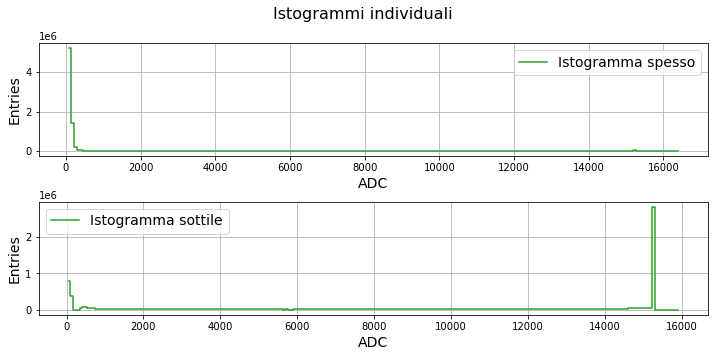

In [8]:
binnn1 = 200 
binnn2 = 250

h1, bins1 = np.histogram(ADC1, bins = binnn1)
h2, bins2 = np.histogram(ADC2, bins = binnn2)

binc1 = bins1[:-1] + bins1[1] - bins1[0]
binc2 = bins2[:-1] + bins2[1] - bins2[0]



fig, ax = plt.subplots(2, 1)#, sharex=True)
#fig.subplots_adjust(hspace=0)
fig.set_size_inches(12,5)
fig.suptitle("Istogrammi individuali", fontsize=16)


opts = {"ds":"steps-mid", "c":"tab:green"}
ax[0].plot(binc1, h1, label = "Istogramma spesso", **opts)
ax[1].plot(binc2, h2, label = "Istogramma sottile", **opts)




for i in ax:
    i.grid()
    i.legend(fontsize=14)
    i.set_ylabel("Entries", fontsize=14)
    i.set_xlabel("ADC", fontsize=14)

fig.subplots_adjust(hspace=.4)


if Export:
    plt.savefig('../RELAZIONE/FIGURE/istogrammi-brutti.eps', format='eps')
plt.show()


Da questo istogramma si vede poco e nulla. Prima di tutto al di sopra di 14 000 ADC potrebbe esserci una saturazione. Proviamo anche a mettere l'asse $y$ in scala logaritmica (`ax.set_yscale("log")`)

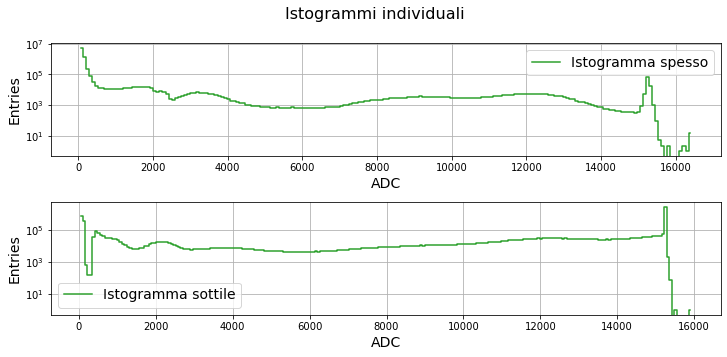

In [9]:
binnn1 = 200 
binnn2 = 250

# Sopra i 14000 c'è la saturazione?
h1, bins1 = np.histogram(ADC1, bins = binnn1)
h2, bins2 = np.histogram(ADC2, bins = binnn2)

binc1 = bins1[:-1] + bins1[1] - bins1[0]
binc2 = bins2[:-1] + bins2[1] - bins2[0]



fig, ax = plt.subplots(2, 1)#, sharex=True)
#fig.subplots_adjust(hspace=0)
fig.set_size_inches(12,5)
fig.suptitle("Istogrammi individuali", fontsize=16)


opts = {"ds":"steps-mid", "c":"tab:green"}
ax[0].plot(binc1, h1, label = "Istogramma spesso", **opts)
ax[1].plot(binc2, h2, label = "Istogramma sottile", **opts)




for i in ax:
    i.grid()
    i.legend(fontsize=14)
    i.set_ylabel("Entries", fontsize=14)
    i.set_xlabel("ADC", fontsize=14)
    i.set_yscale("log")

fig.subplots_adjust(hspace=.4)


if Export:
    plt.savefig('../RELAZIONE/FIGURE/istogrammi-brutti.eps', format='eps')
plt.show()


Proviamo anche a definire un range entro cui effettuare il l'istogramma

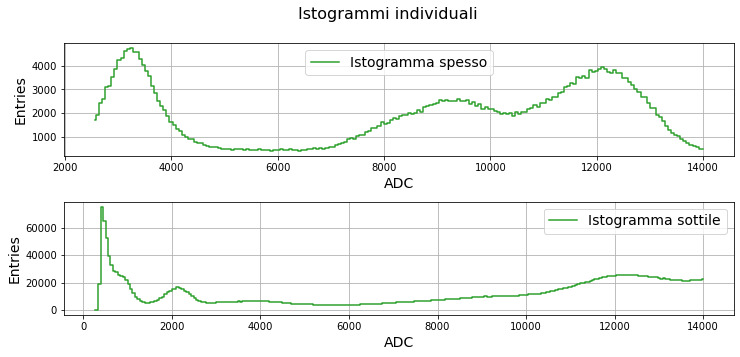

In [10]:
range1 = (2500,14000)
range2 = (200,14000)

binnn1 = 200 
binnn2 = 250

# Sopra i 14000 c'è la saturazione?
h1, bins1 = np.histogram(ADC1, bins = binnn1, range = range1)
h2, bins2 = np.histogram(ADC2, bins = binnn2, range = range2)

# Ottengo il centro dei bin
binc1 = bins1[:-1] + bins1[1] - bins1[0]
binc2 = bins2[:-1] + bins2[1] - bins2[0]



# Plotto gli spettri
fig, ax = plt.subplots(2, 1)#, sharex=True)
#fig.subplots_adjust(hspace=0)
fig.set_size_inches(12,5)
fig.suptitle("Istogrammi individuali", fontsize=16)


opts = {"ds":"steps-mid", "c":"tab:green"}
ax[0].plot(binc1, h1, label = "Istogramma spesso", **opts)
ax[1].plot(binc2, h2, label = "Istogramma sottile", **opts)




for i in ax:
    i.grid()
    i.legend(fontsize=14)
    i.set_ylabel("Entries", fontsize=14)
    i.set_xlabel("ADC", fontsize=14)

fig.subplots_adjust(hspace=.4)


if Export:
    plt.savefig('../RELAZIONE/FIGURE/istogrammi-brutti.eps', format='eps')
plt.show()


Et voilà! Ecco il nostro spettro!

Che cosa mostra questo plot? Questo plot ci mostra la distribuzione dei messimi misurati dai due PMT, ovvero ci dice in ogni intervallo di energie (misurate in unità arbitrarie di ADC) quanti eventi sono stati registrati. L'area sottesa a questo grafico è invece il numero totale di eventi utilizzati (quindi quelli che non sono stati tagliati con la selezione in range).

Da questo plot si vedono emergere alcuni picchi, che dovrebbero corrispondere ai fotoni che vengono emessi.

## Istogrammi 2D
I **biplot** o **istogrammi bidimensionali** possono essere costruiti facilmente sia usando `matplotlib` che `numpy` utilizzando funzioni analoghe. In questo caso utilizziamo il metodo `plt.hist2d`, che accetta come argomenti due vettori, oltre a parametri analoghi al caso monodimensionale (numero di bin, range, ...). Inoltre specifichiamo la [mappa di colore](https://matplotlib.org/stable/tutorials/colors/colormaps.html) che intendiamo utilizzare.

Il biplot effettua un binnaggio lungo i due assi ed in ogni quadratino viene riportato il numero delle volte che il primo canale rientrava in quel bin lungo x ed il secondo canale il quel bin lungo y, ovvero il numero di volte che il primo PMT ha visto una certa energia ed il secondo PMT un'altra certa energia. Il numero di volte viene codificato con un colore.

Questo tipo di plot sono molto potenti in quanto permettono di studiare le correlazioni tra i due canali. Nel nostro caso abbiamo due fotoni che possono venire emessi in coincidenza (a distanza di pochissimo tempo) e venir rivelati uno per ciascun PMT: questo giustifica gli addensamenti che si notano.

Iniziamo quindi a provare a costruire un istogramma bidimensionale

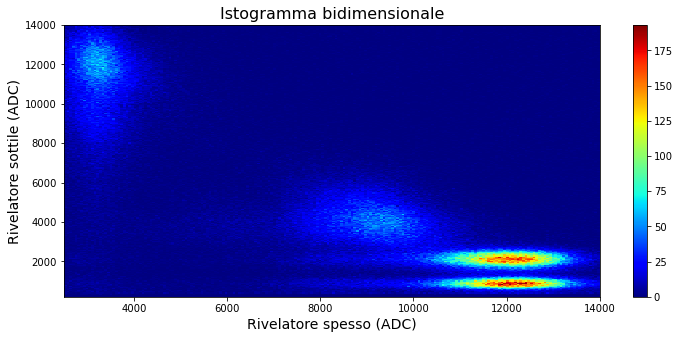

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.set_title("Istogramma bidimensionale", fontsize=16)

myPlot = ax.hist2d(ADC1, ADC2, bins = (binnn1, binnn2), range = (range1, range2), 
                   cmap = mpl.cm.jet)

ax.set_xlabel("Rivelatore spesso (ADC)", fontsize = 14)
ax.set_ylabel("Rivelatore sottile (ADC)", fontsize = 14)

fig.colorbar(myPlot[3], ax = ax)



if Export:
    plt.savefig('../RELAZIONE/FIGURE/istogramma-2d.eps', format='eps')
plt.show()

Spesso può essere utile consultare gli istogrammi in scala logaritmica per accentuare piccole differenze. Per farlo è sufficientemente specificare tra gli argomenti `norm = mpl.colors.LogNorm()`

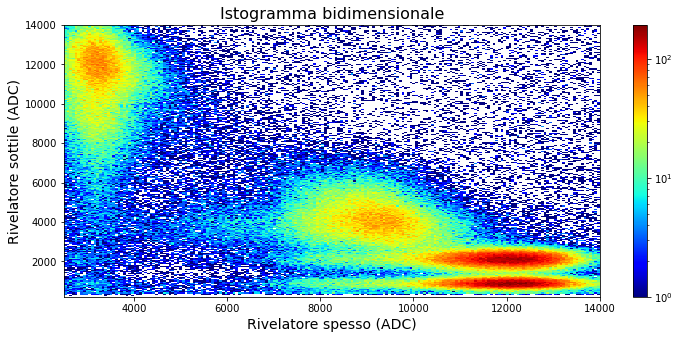

In [12]:
import matplotlib as mpl

fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.set_title("Istogramma bidimensionale", fontsize=16)

myPlot = ax.hist2d(ADC1, ADC2, bins = (binnn1, binnn2), range = (range1, range2), 
                    norm = mpl.colors.LogNorm(), cmap = mpl.cm.jet)

ax.set_xlabel("Rivelatore spesso (ADC)", fontsize = 14)
ax.set_ylabel("Rivelatore sottile (ADC)", fontsize = 14)

fig.colorbar(myPlot[3], ax = ax)



if Export:
    plt.savefig('../RELAZIONE/FIGURE/istogramma-2d.eps', format='eps')
plt.show()

Notiamo che tale grafico ha qualcosa di visualmente fastidioso, in particolare introduce una discontinuità, alternando bianco e blu. Ciò è legato al fatto che dove si ha il bianco si hanno 0 conteggi, il cui logaritmo non è definito. Poiché i nostri dati sono sempre riferiti a conteggi, quindi sono 0, 1, 2.... può essere utile ridefinire a 0 il caso in cui vi siano stati 0 conteggi, mantenendo così l'uniformità. Il modulo `copy` ci permette di copiare un oggetto in modo completo, in modo tale che noi possiamo modificare una versione clonata di un oggetto di libreria.

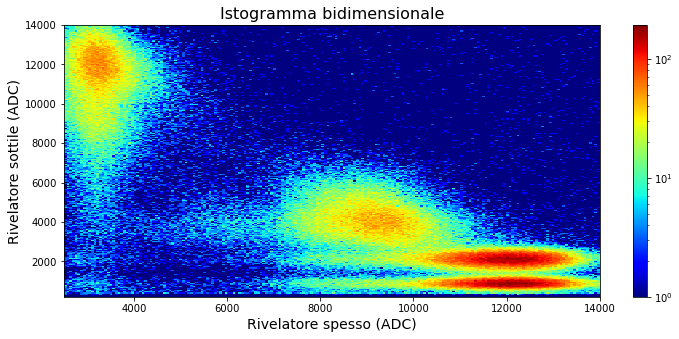

In [13]:
import copy 

# Esistono problemi con i pixels zero: li risolvo 
my_cmap = copy.copy(mpl.cm.jet) # copy the default cmap
my_cmap.set_bad(my_cmap(0))

fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.set_title("Istogramma bidimensionale", fontsize=16)

myPlot = ax.hist2d(ADC1, ADC2, bins = (binnn1, binnn2), range = (range1, range2), 
                    norm = mpl.colors.LogNorm(), cmap = my_cmap)

ax.set_xlabel("Rivelatore spesso (ADC)", fontsize = 14)
ax.set_ylabel("Rivelatore sottile (ADC)", fontsize = 14)

fig.colorbar(myPlot[3], ax = ax)



if Export:
    plt.savefig('../RELAZIONE/FIGURE/istogramma-2d.eps', format='eps')
plt.show()

Talvolta può essere comodo (soprattutto per sovrapporre due istogrammi bidimensionali, nel cui caso servirebbero "4 coordinate") costruire un "boxplot", ovvero un istogramma 2D, dove l'informazione sul numero di conteggi non è codificata nel colore ma nella larghezza del marker. In questo senso, utilizzando differenti colori si possono sovrapporre più istogrammi bidimensionali.

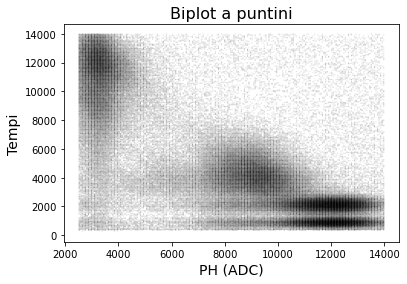

In [14]:
# Creo la mappa di punti da plottare
myGrid = np.meshgrid(myPlot[1][:-1] + (myPlot[1][1]-myPlot[1][0])/2, 
                      myPlot[2][:-1] + (myPlot[2][1]-myPlot[2][0])/2)

z1 = myPlot[0].T.flatten(order = "C")
x1 = myGrid[0].flatten(order = "C")
y1 = myGrid[1].flatten(order = "C")



# Effettuo il plot
fig, ax = plt.subplots()
fig.subplots_adjust(wspace = .4)
ax.scatter(x1, y1, color = "k", alpha = 1, marker = ".",
            s = .01 * z1,)

    
ax.set_xlabel("PH (ADC)", fontsize = 14)
ax.set_ylabel("Tempi", fontsize = 14)
ax.set_title(f"Biplot a puntini", fontsize = 16)
    
 

if Export: 
    plt.savefig(f'../LATEX/FIGURE/plot-lab/biplot.eps', format='eps')
plt.show() 

Un'altra cosa utile può essere di tracciare delle **curve di livello**, ovvero delle curve che uniscono punti alla stessa quota. Anche questa operazione può essere fatta comodamente sfruttando `plt.contour`.

In questa cella mostro anche come si possano disegnare dei rettangoli utilizzando i [patches](https://matplotlib.org/stable/api/patches_api.html) e come si possano disegnare delle frecce con testo utilizzando [`plt.annotate`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html).

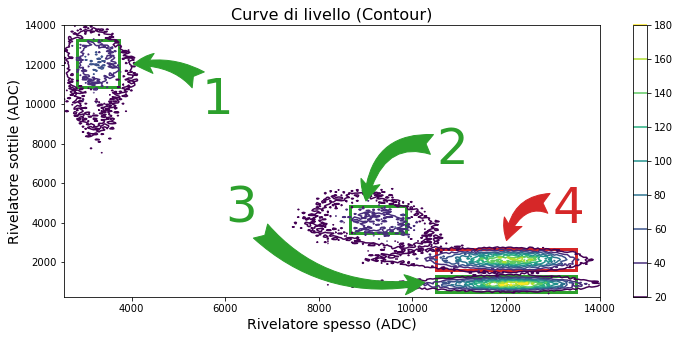

In [15]:
from matplotlib.patches import Rectangle

# Trovo i centri dei bin dell'istogramma bidimensionale
xcentr = myPlot[1][:-1] + myPlot[1][1] - myPlot[1][0]
ycentr = myPlot[2][:-1] + myPlot[2][1] - myPlot[2][0]


fig, ax = plt.subplots()
fig.set_size_inches(12,5)
ax.set_title("Curve di livello (Contour)", fontsize=16)

ax.set_xlabel("Rivelatore spesso (ADC)", fontsize = 14)
ax.set_ylabel("Rivelatore sottile (ADC)", fontsize = 14)


myContour = ax.contour(*np.meshgrid(xcentr, ycentr, indexing = "ij"), 
                       myPlot[0], levels = range(20,200,20))


# Definisco gli oggetti rettangolo che stamperò
rect1 = Rectangle((2840,10850), width = 900, height = 2400, 
                  ec='tab:green', fc='none', lw = 3)
rect2 = Rectangle((8663,3470), width = 1200, height = 1400, 
                  ec='tab:green', fc='none', lw = 3)

rect3 = Rectangle((10500,490), width = 3000, height = 800, 
                  ec='tab:green', fc='none', lw = 3)
rect4 = Rectangle((10500,1600), width = 3000, height = 1050, 
                  ec='tab:red', fc='none', lw = 3)

# Questa lista serve per la cella della funzione successiva
rectList = (rect1, rect2, rect3, rect4)


# Agguiungo i rettangoli alla figura
ax.add_patch(rect1)
ax.add_patch(rect2)
ax.add_patch(rect3)
ax.add_patch(rect4)

fig.colorbar(myContour)



# Stampo le frecce con il testo
plt.annotate("1", xytext=(5500, 9500), xy=(4000, 12000), xycoords='data',
             arrowprops=dict(arrowstyle="fancy",
                            connectionstyle="arc3, rad=.3", color="tab:green"),
             c="tab:green", size=50)

plt.annotate("2", xytext=(10500, 7000), xy=(9000, 5000), xycoords='data',
             arrowprops=dict(arrowstyle="fancy",
                            connectionstyle="arc3, rad=.6", color="tab:green"),
             c="tab:green", size=50)

plt.annotate("3", xytext=(6000, 4000), xy=(10300, 1000), xycoords='data',
             arrowprops=dict(arrowstyle="fancy",
                            connectionstyle="arc3, rad=.3", color="tab:green"),
             c="tab:green", size=50)

plt.annotate("4", xytext=(13000, 4000), xy=(12000, 3000), xycoords='data',
             arrowprops=dict(arrowstyle="fancy",
                            connectionstyle="arc3, rad=.6", color="tab:red"),
             c="tab:red", size=50)


if Export:
    plt.savefig('../RELAZIONE/FIGURE/contour.eps', format='eps')
plt.show()

Dalla mia relazione:
<blockquote>
Le regioni 1 e 2 corrispondono al caso in cui un fotone da 122 keV giunga
all’interno dell’area sensibile di un rivelatore, estragga un elettrone per effetto
fotoelettrico ma il raggio X di diseccitazione fugga nel secondo detector. Benché
non siano ugualmente sensibili ai fotoni a 122 keV, tale effetto può verificarsi per
entrambi i detector. Si segnala come possa anche venir emesso un unico fotone
da 136 keV: tuttavia, essendo di un ordine di grandezza inferiore in intensità
rispetto a quello da 122 keV, tale fotone non viene rivelato sottoforma di picco e
contribuisce ad un allargamento della distribuzione del picco da 122 keV.

La regione 3 corrisponde al caso in cui nel detector spesso venga rivelato un
fotone da 122 keV e nel rivelatore sottile venga rivelato un fotone da 6.4 keV:
quest’ultimo corrisponde ad un raggio X caratteristico del $^{57}$Fe presente all’interno
della sorgente prodotto dal fotone a 14.4 keV che non riesce a fuoriuscire dalla
sorgente.

Infine la regione 4 rappresenta la regione di interesse: in tale regione il
rivelatore spesso rivela il fotone da 122 keV mentre quello sottile il fotone da
14.4 keV. Tali fotoni vengono emessi in cascata nel decadimento. Solo per questi
eventi verrà valutata la differenza temporale usata per il calcolo della lifetime
dello stato eccitato a 14.4 keV.
</blockquote>

## FIT

Una volta che sono stati definiti gli spettri, il passo successivo è di effettuare il fit in una regione ben precisa. Per essere sicuri di andare a considerare solo eventi di interesse, sono state effettuate le proiezioni solamente all'interno dei rettangoli: questo è un modo per effettuare dei tagli, per selezionare solamente un sottoinsieme dei dati.

I picchi verranno fittati con una funzione gaussiana: inizio quindi definendo la funzione `gauss` con cui andrò ad effettuare il fit.

Successivamente, poichè vi sono una serie di operazioni da ripetere per ciascuna regione, definisco una funzione che mi permette di mantenere compatto il codice.

- Nella prima parte della funzione vengono ottenute le coordinate della regione racchiusa nel rettangolo.
- Nella seconda parte della funzione vengono effettuate le somme per riga e per colonna all'interno del rettangolo
- Nella terza parte della funzione vengono effettuati i fit degli spettri con una gaussiana. Notiamo in particolare come il parametro `absolute_sigma = True` permetta di utilizzare nel fit gli **errori veri** e non degli errori riscalati di un certo fattore tale per cui il $\bar\chi^2\approx 1$
- Gli errori estratti dal fit sono quindi salvati in delle liste e verranno letti in seguito
- Nella quarta parte della funzione vengono mostrati gli spettri con la selezione effettuata (le proiezioni nel rettangolo) a cui viene sovrapposta la curva fittata e con i metodi `axvline` e `axhline` vengono visualizzate le regioni entro cui è stato effettuato il fit
- Nella quinta parte viene calcolato il $\bar\chi^2$

In [16]:
def gauss(x,a,mu,sigma):
    return a/(sigma*np.sqrt(2*np.pi)) * np.exp(-(x-mu)**2/(2*(sigma**2)))


lista_popt = []
lista_pcov = []
lista_chi2 = []

def calibra(idxRect, startingPts):
    
    # PRIMA PARTE
    # Ottengo l'oggetto rettangolo
    myRect = rectList[idxRect]
    
    
    # Ottengo quindi le coordinate della regione delimitata dal rettangolo
    startx = myRect.get_x()
    endx = startx + myRect.get_width()
    
    idx_startx = np.where(xcentr >= startx)[0][0]
    idx_endx = np.where(xcentr >= endx)[0][0]
    
    
    starty = myRect.get_y()
    endy = starty + myRect.get_height()
    
    idx_starty = np.where(ycentr >= starty)[0][0]
    idx_endy = np.where(ycentr >= endy)[0][0]
    
    
    
    subdata = myPlot[0][ idx_startx:idx_endx , idx_starty:idx_endy]
    subdata_sqrt = np.sqrt(subdata)
    
    
    
    
    # SECONDA PARTE
    # *** EFFETTUO LE PROIEZIONI ***
    # Alla terza riga proietto per tutta la colonna/riga, di cui il 
    # rettangolo è intersezione
    
    # Quello che vede il rivelatore sottile, proietto a sx
    proiez_sottile = np.sum(subdata, axis = 0)
    proiez_sottile_sqrt = np.sqrt(np.sum(subdata_sqrt**2, axis = 0))
    
    proiez_sottile_completo = np.sum( myPlot[0][idx_startx:idx_endx , :], axis = 0)
    
    # Quello che vede il rivelatore spesso, proietto sotto
    proiez_spesso = np.sum(subdata, axis = 1)
    proiez_spesso_sqrt = np.sqrt(np.sum(subdata_sqrt**2, axis = 1))
    
    proiez_spesso_completo = np.sum( myPlot[0][:, idx_starty:idx_endy], axis = 1)

    
    
    
    # Ottengo le x delle proiezioni
    vect_spesso = np.array([i for i in xcentr if (i >= startx) & (i<=endx)])
    vect_sottile = np.array([i for i in ycentr if (i >= starty) & (i<=endy)])

    

    # TERZA PARTE
    # fitto con gaussiane
    popt_spesso, pcov_spesso = curve_fit(gauss, vect_spesso, proiez_spesso, 
                                         sigma = proiez_spesso_sqrt, 
                                         p0 = startingPts[0], absolute_sigma = True)
    
    popt_sottile, pcov_sottile = curve_fit(gauss, vect_sottile, proiez_sottile, 
                                         sigma = proiez_sottile_sqrt, 
                                         p0 = startingPts[1], absolute_sigma = True)
    
    
    lista_popt.append([popt_spesso, popt_sottile])
    lista_pcov.append([pcov_spesso, pcov_sottile])
    
    
    
    
    # QUARTA PARTE
    # *** LO PLOTTO ***
    
    
    fig, ax = plt.subplots(2, 1)#, sharex=True)
    #fig.subplots_adjust(hspace=0)
    fig.set_size_inches(12,5)
    fig.subplots_adjust(hspace=.4)

    
    fig.suptitle(f"Regione {idxRect+1}", fontsize=16)
    
    # Plotto le proiezioni (tanto dopo si vede già tutto)
    #ax[0].plot(vect_spesso, proiez_spesso, label = "Proiezione rivelatore spesso")
    #ax[1].plot(vect_sottile, proiez_sottile, label = "Proiezione rivelatore sottile")
    
    
    # Plotto la somma su tutta la striscia
    opts = {"c":"tab:green"}
    ax[0].plot(xcentr, proiez_spesso_completo,  
               label = "Proiezione rivelatore spesso", **opts)
    ax[1].plot(ycentr, proiez_sottile_completo,  
               label = "Proiezione rivelatore sottile", **opts)
    
    
    # Plotto le curve fittate
    opts = {"label":"Curva fittata", "ls":":", "c":"k"}
    ax[0].plot(vect_spesso, gauss(vect_spesso, *popt_spesso), **opts)
    ax[1].plot(vect_sottile, gauss(vect_sottile, *popt_sottile), **opts)
    
    # delimito le regioni di fit
    opts = {"ls":"--", "c":"grey"}
    ax[0].axvline(x=startx, **opts)
    ax[0].axvline(x=endx, **opts)
    ax[1].axvline(x=starty, **opts)
    ax[1].axvline(x=endy, **opts)
    
    
    for i in ax:
        i.grid()
        i.legend(fontsize=14)
        i.set_ylabel("Entries", fontsize=14)
        i.set_xlabel("ADC", fontsize=14)
    

    if Export:
        plt.savefig(f'../RELAZIONE/FIGURE/fit-gauss-{idxRect}.eps', format='eps')
    plt.show()
    
    
    # QUINTA PARTE
    mychi2_spesso = np.sum(((proiez_spesso-gauss(vect_spesso, *popt_spesso))/proiez_spesso_sqrt)**2) / (len(proiez_spesso)-3)
    mychi2_sottile = np.sum(((proiez_sottile-gauss(vect_sottile, *popt_sottile))/proiez_sottile_sqrt)**2) / (len(proiez_sottile)-3)
    
    lista_chi2.append([mychi2_spesso, mychi2_sottile])



Vado quindi a richiamare la funzione per ciascuna regione

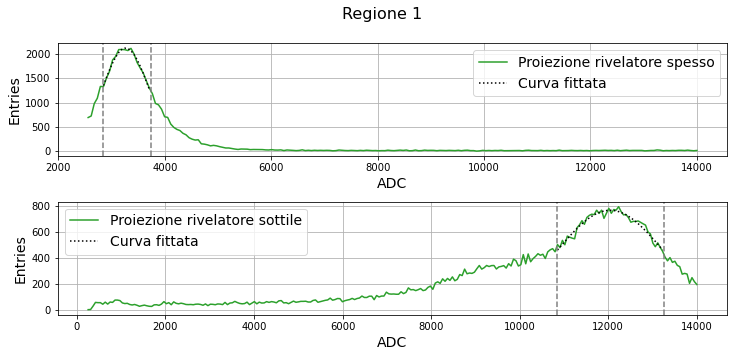

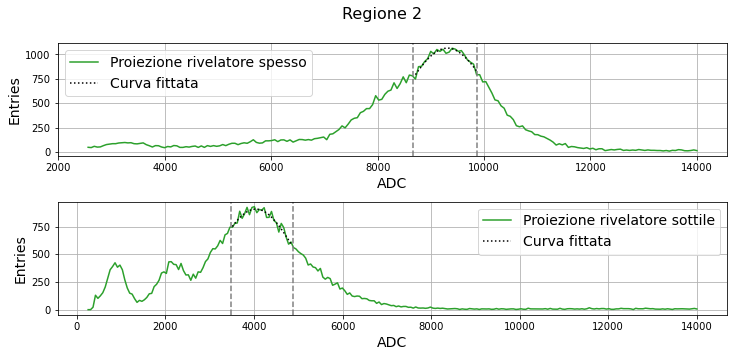

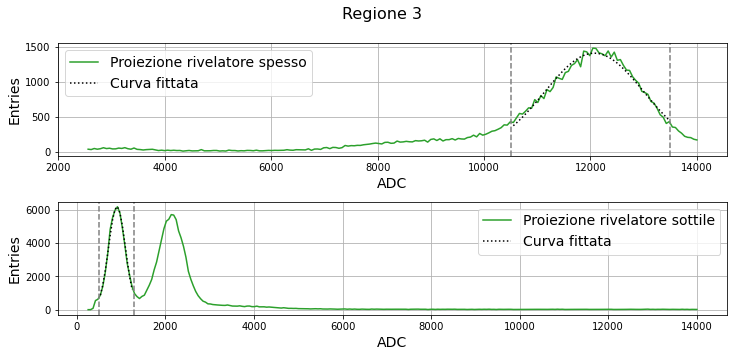

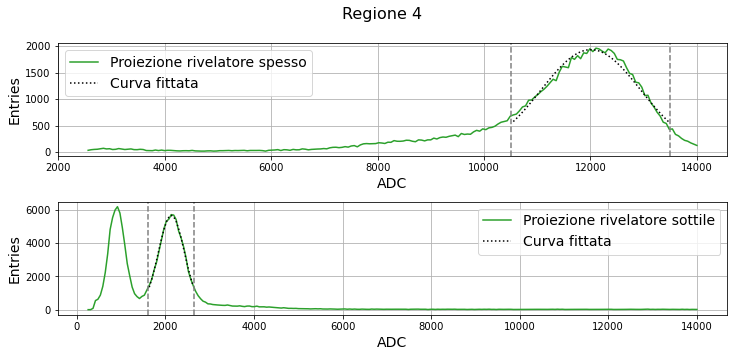

In [17]:
calibra(0, ((100, 3300, 400), (60, 12000, 2000))) # Regione 1
calibra(1, ((100, 12000, 2000), (60, 2100, 700))) # Regione 2
calibra(2, ((100, 12000, 2000), (60, 2100, 700))) # Regione 3
calibra(3, ((100, 12000, 2000), (60, 2100, 700))) # Regione 4

## Retta di calibrazione
Una volta che sono stati individuati i picchi con il fit gaussiano, è possibile convertire gli spettri da unità arbitrarie di ADC ad energie in keV. Sapendo l'energia vera dei picchi (vedi sopra) ed avendo stabilito i picchi che si vedono quali energie dovrebbero avere, è possibile plottare l'energia in unità di ADC (la $x$ del picco, la $\mu$ estratta dal fit) in funzione dell'energia vera. Questa retta costituisce la retta di calibrazione (più precisamente l'inverso della retta di calibrazione, ovvero quella funzione che accetta come argomento un'energia in ADC e restituisce l'energia in keV.

Inizio quindi definendo la funzione di fit. È vero che per una retta esiste la funzione [polifit](https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html), ma ci sono state delle volte in cui mi ha dato problemi, e comunque non si possono specificare gli errori. 

Successivamente definisco dei vettori contenenti i valori veri dei picchi, i valori estratti dal fit e gli errori.

Procedo quindi effettuando il fit ed andando ad effettuare il plot

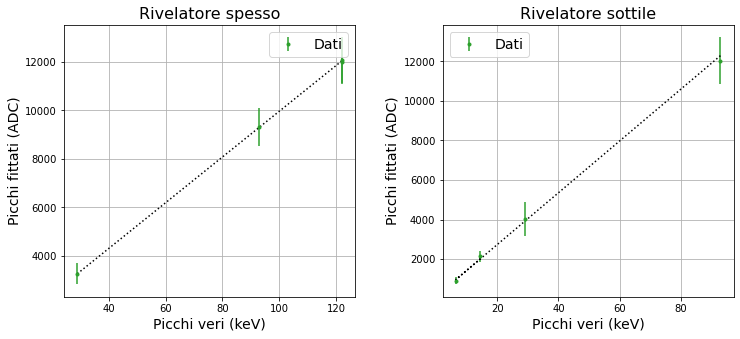

Chi2 spesso: 0.001224772386488492
Chi2 sottile: 4.1707528150819195


In [18]:
def line(x,a,b):
    return a*x+b


picchiVeriSpesso = np.array((29, 93, 122, 122))
picchiVeriSottile = np.array((93, 29, 6.4, 14.4))

picchiSpesso = np.array([i[0][1] for i in lista_popt])
sigmaSpesso = np.array([i[0][2] for i in lista_popt])
errPicchiSpesso = np.array([np.sqrt(i[0][1,1]) for i in lista_pcov])

picchiSottile = np.array([i[1][1] for i in lista_popt])
sigmaSottile = np.array([i[1][2] for i in lista_popt])
errPicchiSottile = np.array([np.sqrt(i[1][1,1]) for i in lista_pcov])


# fit lineari
popt1, pcov1 = curve_fit(line, picchiVeriSpesso, picchiSpesso, 
                         sigma = sigmaSpesso, absolute_sigma = True)
popt2, pcov2 = curve_fit(line, picchiVeriSottile, picchiSottile, 
                         sigma = sigmaSottile, absolute_sigma = True)


fig, ax = plt.subplots(1,2)#, sharex=True)
fig.subplots_adjust(wspace=.3)
fig.set_size_inches(12,5)


# Plotto i punti
opts = {"label":"Dati", "ls":"", "c":"tab:green", "marker":"."}

ax[0].errorbar(picchiVeriSpesso, picchiSpesso,    
               yerr = sigmaSpesso, **opts )
ax[1].errorbar(picchiVeriSottile, picchiSottile, 
               yerr = sigmaSottile, **opts )

# Plotto le curve fittate
opts = {"ls":":", "c":"k"}
ax[0].plot(picchiVeriSpesso, line(picchiVeriSpesso, *popt1), **opts)
ax[1].plot(picchiVeriSottile, line(picchiVeriSottile, *popt2), **opts)

ax[0].set_title("Rivelatore spesso", fontsize = 16)
ax[1].set_title("Rivelatore sottile", fontsize = 16)


    
for i in ax:
    i.grid()
    i.legend(fontsize=14)
    i.set_ylabel("Picchi fittati (ADC)", fontsize=14)
    i.set_xlabel("Picchi veri (keV)", fontsize=14)


if Export:
    plt.savefig(f'../RELAZIONE/FIGURE/retta-cal.eps', format='eps')
plt.show()


myChi2_Spesso = np.sum((( picchiSpesso - line(picchiVeriSpesso, *popt1)) /sigmaSpesso )**2) /  (len(picchiVeriSpesso)-2)
myChi2_Sottile = np.sum((( picchiSottile - line(picchiVeriSottile, *popt1)) /sigmaSottile )**2) /  (len(picchiVeriSottile)-2)


print(f"Chi2 spesso: {myChi2_Spesso}")
print(f"Chi2 sottile: {myChi2_Sottile}")

Siccome io sono pigro, questo è un modo di farsi aiutare dal pitone a formattare le tabelle $\LaTeX $, cosicchè sia sufficiente copiare questo output ed incollarlo nella relazione, senza dover inserire ogni numero a mano.

In [19]:
#Stampo la tabella con i parametri delle gaussiane

# Spesso
for i in range(len(lista_popt)):
    print(f"\t& {i+1}\t& {lista_popt[i][0][1]:.2f}\t& {np.sqrt(lista_pcov[i][0][1,1]):.2f}\t& {lista_popt[i][0][2]:.2f}\t& {np.sqrt(lista_pcov[i][0][2,2]):.2f}\t& {lista_chi2[i][0]:.2f} \\\\")

print("\n")

# Sottile
for i in range(len(lista_popt)):
    print(f"\t& {i+1}\t& {lista_popt[i][1][1]:.2f}\t& {np.sqrt(lista_pcov[i][1][1,1]):.2f}\t& {lista_popt[i][1][2]:.2f}\t& {np.sqrt(lista_pcov[i][1][2,2]):.2f}\t& {lista_chi2[i][1]:.2f} \\\\")


	& 1	& 3262.70	& 4.66	& 440.06	& 8.53	& 0.82 \\
	& 2	& 9309.55	& 12.92	& 780.83	& 31.59	& 0.89 \\
	& 3	& 12072.10	& 5.35	& 936.21	& 6.44	& 3.85 \\
	& 4	& 12007.31	& 4.58	& 936.08	& 5.44	& 6.36 \\


	& 1	& 12041.58	& 12.56	& 1177.26	& 23.28	& 1.09 \\
	& 2	& 4043.27	& 16.41	& 861.08	& 32.74	& 1.43 \\
	& 3	& 906.02	& 0.95	& 189.30	& 0.91	& 7.06 \\
	& 4	& 2135.24	& 1.35	& 295.28	& 1.47	& 2.91 \\


La keyword `lambda` permette di definire una sorta di funzione tutto su una riga. In genere le uso quando c'è un conto da fare, per esempio una propagazione degli errori, in modo tale da non doverlo ripetere più volte, ma al tempo stesso non dovermi scomodare a definire una funzione vera e propria per uan sola riga.

In [20]:
#Stampo una tabella con i picchi veri, quelli fittati in kev e errore picco fittato kev, errore, picco vero

err_retta = lambda x,dx,m,dm,q,dq : np.sqrt((x*dm)**2 + (m*dx)**2 + dq**2)

# Spesso
m = 1/popt1[0]
q = -popt1[1]/popt1[0]
errm = (1/(m**2)) * np.sqrt(pcov1[0,0])
errq = np.sqrt((np.sqrt(pcov1[1,1]/m))**2 + ((q/(m**2))*np.sqrt(pcov1[0,0]))**2)
for i in range(len(lista_popt)):
    print(f"\t& {picchiVeriSpesso[i]}\t& {line(lista_popt[i][0][1], m, q):.2f}\t& {err_retta(picchiSpesso[i],errPicchiSpesso[i],m,errm,q,errq):.2f} \\\\") 
    
 
# Sottile
m = 1/popt2[0]
q = -popt2[1] / popt2[0]
errm = (1/(m**2)) * np.sqrt(pcov2[0,0])
errq = np.sqrt((np.sqrt(pcov2[1,1]/m))**2 + ((q/(m**2))*np.sqrt(pcov2[0,0]))**2)

for i in range(len(lista_popt)):
    print(f"\t& {picchiVeriSottile[i]}\t& {line(lista_popt[i][1][1], m, q):.2f}\t& {err_retta(picchiSottile[i],errPicchiSottile[i],m,errm,q,errq):.2f} \\\\") 



	& 29	& 28.99	& 234416583.97 \\
	& 93	& 93.05	& 668865576.43 \\
	& 122	& 122.32	& 867347567.34 \\
	& 122	& 121.63	& 862692627.28 \\
	& 93.0	& 91.08	& 2660625956.10 \\
	& 29.0	& 29.97	& 893373667.92 \\
	& 6.4	& 6.00	& 200188316.19 \\
	& 14.4	& 15.39	& 471787642.99 \\


In questa cella vado semplicemente a definire le regioni che utilizzerò per calcolare il tempo di vita. La prima metà della cella è già stata vista prima e riportata per comodità, nella seconda parte vado praticamente a fissare e visualizzare le soglie (definite in termini di $\sigma$. Stiamo considerando solamente la regione di interesse

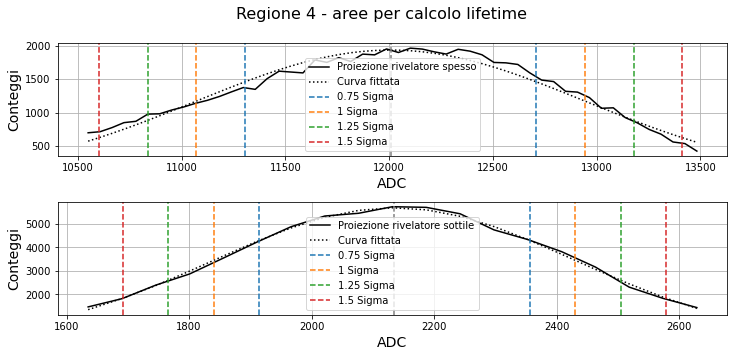

In [21]:
myRect = rectList[3]

startx = myRect.get_x()
endx = startx + myRect.get_width()

idx_startx = np.where(xcentr >= startx)[0][0]
idx_endx = np.where(xcentr >= endx)[0][0]


starty = myRect.get_y()
endy = starty + myRect.get_height()

idx_starty = np.where(ycentr >= starty)[0][0]
idx_endy = np.where(ycentr >= endy)[0][0]



subdata = myPlot[0][ idx_startx:idx_endx , idx_starty:idx_endy]
subdata_sqrt = np.sqrt(subdata)



# Quello che vede il rivelatore sottile, proietto a sx
proiez_sottile = np.sum(subdata, axis = 0)
proiez_sottile_sqrt = np.sqrt(np.sum(subdata_sqrt**2, axis = 0))

# Quello che vede il rivelatore spesso, proietto sotto
proiez_spesso = np.sum(subdata, axis = 1)
proiez_spesso_sqrt = np.sqrt(np.sum(subdata_sqrt**2, axis = 1))



vect_spesso = np.array([i for i in xcentr if (i >= startx) & (i<=endx)])
vect_sottile = np.array([i for i in ycentr if (i >= starty) & (i<=endy)])



# fitto con gaussiane
popt_spesso, pcov_spesso = curve_fit(gauss, vect_spesso, proiez_spesso, 
                                     sigma = proiez_spesso_sqrt, 
                                     p0 = lista_popt[3][0])

popt_sottile, pcov_sottile = curve_fit(gauss, vect_sottile, proiez_sottile, 
                                     sigma = proiez_sottile_sqrt, 
                                     p0 = lista_popt[3][1])







fig, ax = plt.subplots(2, 1)#, sharex=True)
fig.subplots_adjust(hspace=.4)
fig.set_size_inches(12,5)


fig.suptitle(f"Regione 4 - aree per calcolo lifetime", fontsize=16)

# Plotto le proiezioni
ax[0].plot(vect_spesso, proiez_spesso, "k", label = "Proiezione rivelatore spesso")
ax[1].plot(vect_sottile, proiez_sottile, "k", label = "Proiezione rivelatore sottile")


# Plotto le curve fittate
ax[0].plot(vect_spesso, gauss(vect_spesso, *popt_spesso), ":k", 
           label = "Curva fittata")
ax[1].plot(vect_sottile, gauss(vect_sottile, *popt_sottile), ":k", 
           label = "Curva fittata")





# Parte nuova
# Disegno delle linee ad 1 sigma
ax[0].axvline(lista_popt[3][0][1], ls = "--", c="grey")

ax[0].axvline(lista_popt[3][0][1] + .75*lista_popt[3][0][2], ls = "--", c="tab:blue", label = "0.75 Sigma")
ax[0].axvline(lista_popt[3][0][1] - .75*lista_popt[3][0][2], ls = "--", c="tab:blue")
ax[0].axvline(lista_popt[3][0][1] + 1*lista_popt[3][0][2], ls = "--", c="tab:orange", label = "1 Sigma")
ax[0].axvline(lista_popt[3][0][1] - 1*lista_popt[3][0][2], ls = "--", c="tab:orange")
ax[0].axvline(lista_popt[3][0][1] + 1.25*lista_popt[3][0][2], ls = "--", c="tab:green", label = "1.25 Sigma")
ax[0].axvline(lista_popt[3][0][1] - 1.25*lista_popt[3][0][2], ls = "--", c="tab:green")
ax[0].axvline(lista_popt[3][0][1] + 1.5*lista_popt[3][0][2], ls = "--", c="tab:red", label = "1.5 Sigma")
ax[0].axvline(lista_popt[3][0][1] - 1.5*lista_popt[3][0][2], ls = "--", c="tab:red")



ax[1].axvline(lista_popt[3][1][1], ls = "--", c="grey")

ax[1].axvline(lista_popt[3][1][1] + .75*lista_popt[3][1][2], ls = "--", c="tab:blue", label = "0.75 Sigma")
ax[1].axvline(lista_popt[3][1][1] - .75*lista_popt[3][1][2], ls = "--", c="tab:blue")
ax[1].axvline(lista_popt[3][1][1] + 1*lista_popt[3][1][2], ls = "--", c="tab:orange", label = "1 Sigma")
ax[1].axvline(lista_popt[3][1][1] - 1*lista_popt[3][1][2], ls = "--", c="tab:orange")
ax[1].axvline(lista_popt[3][1][1] + 1.25*lista_popt[3][1][2], ls = "--", c="tab:green", label = "1.25 Sigma")
ax[1].axvline(lista_popt[3][1][1] - 1.25*lista_popt[3][1][2], ls = "--", c="tab:green")
ax[1].axvline(lista_popt[3][1][1] + 1.5*lista_popt[3][1][2], ls = "--", c="tab:red", label = "1.5 Sigma")
ax[1].axvline(lista_popt[3][1][1] - 1.5*lista_popt[3][1][2], ls = "--", c="tab:red")


for i in ax:
    i.grid()
    i.legend(fontsize=10)
    i.set_ylabel("Conteggi", fontsize=14)
    i.set_xlabel("ADC", fontsize=14)



if Export:
    plt.savefig(f'../RELAZIONE/FIGURE/aree.eps', format='eps')
plt.show()

## Calcolo lifetime
### Con taglio

Per calcolare la lifetime sono state calcolate le differenze nei tempi di arrivo relative ai due PMT nella regione di interesse, con bordi fissati in termini di $\sigma$, come descritti nella cella superiore.

Inizio quindi definendo la funzione esponenziale con cui fare il fit. Anche in questo caso, poiché devo ripetere una medesima operazione per 4 volte, vado a definire una funzione per praticità.

Dopo aver valutato le differenze nei tempi di arrivo per gli eventi scelti, vado a studiarne la distribuzione (ovvero a fare un istogramma). Infine viene fittata la parte destra dell'istogramma con un esponenziale decrescente, la cui $\tau$ rappresenta la vita media.

Le due celle seguenti sono uguali con una sola differenza sostanziale: nella prima vado a ciclare con un `for` per ogni evento per stabilire se la condizione è soddisfatta. Poiché ho definito 4 regioni, vado a fare $8*4 = 32$ milioni di iterazioni, mentre nel secondo caso uso la vettorializzazione. Il magic commando `%%time` permette di calcolare il tempo per effettuare l'operazione: notiamo come nel primo caso stiamo parlando di un minuto, mentre nel secondo caso di un secondo, da cui impariamo la lezione che, se non strettamente vitali, **I CICLI FOR SI DEVONO EVITARE**, soprattutto quando si lavora con vettori e soprattutto se questi hanno una dimensione notevole.

#### Modo da evitare

Sigma: 0.75 - Vita media: 142.43041129735968 ± 0.9552548805981675
Sigma: 1 - Vita media: 141.92087670841832 ± 0.7619644296803915
Sigma: 1.25 - Vita media: 145.8703006403094 ± 0.6917418886702111
Sigma: 1.5 - Vita media: 143.66011993840195 ± 0.6547872925302737


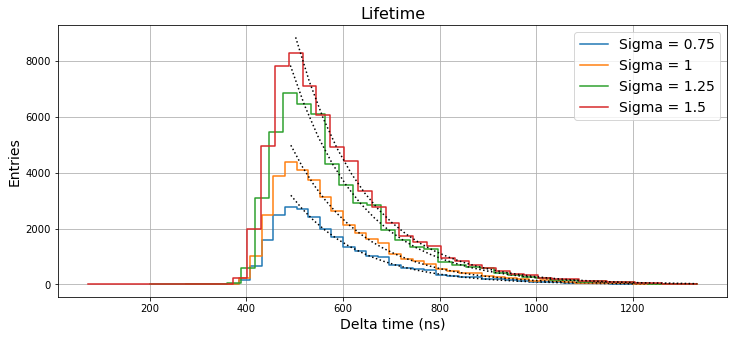

Wall time: 31.8 s


In [22]:
%%time

def myExp(x,a,tau):
    return a*np.exp(-x/tau)

listaSigme = []
listaLifetime = []
listaErrLifetime = []
nuovalistachi2 = []





def calcolaLifetime(nsigma, altezza, numBins):
    
    ADC1_min = lista_popt[3][0][1] - nsigma*lista_popt[3][0][2]
    ADC1_max = lista_popt[3][0][1] + nsigma*lista_popt[3][0][2]
    ADC2_min = lista_popt[3][1][1] - nsigma*lista_popt[3][1][2]
    ADC2_max = lista_popt[3][1][1] + nsigma*lista_popt[3][1][2]

    
    listaTempi = []
    for i in range(len(time)):
        if (ADC1[i] >= ADC1_min) & (ADC1[i] <= ADC1_max) & \
           (ADC2[i] >= ADC2_min) & (ADC2[i] <= ADC2_max) :
               
               listaTempi.append(np.abs(time1[i] - time2[i]))
               
              
    listaTempi = np.array(listaTempi) 
    
    """
    cond = (ADC1 >= ADC1_min) & (ADC1 <= ADC1_max) & \
           (ADC2 >= ADC2_min) & (ADC2 <= ADC2_max)
    
    listaTempi = np.abs(time1[cond] - time2[cond])
    """
      


    
    h, bins = np.histogram(listaTempi, bins=numBins)
    binc = bins[:-1] + bins[1] - bins[0]
    
    plt.plot(binc, h, ds = "steps-mid", label = f"Sigma = {nsigma}")
    
    
    # fitto con un exp
    condizione = binc > 480
    xVect = binc[condizione]
    yVect = h[condizione]
    
    popt, pcov = curve_fit(myExp, xVect, yVect, sigma = np.sqrt(yVect),
                           p0 = [altezza, 1.41920784e+02], absolute_sigma = True)
    
    plt.plot(xVect, myExp(xVect,*popt), ls = ":", c="k")
    

    print(f"Sigma: {nsigma} - Vita media: {popt[1]} ± {np.sqrt(pcov[1,1])}")

    listaSigme.append(nsigma)
    listaLifetime.append(popt[1])  
    listaErrLifetime.append(np.sqrt(pcov[1,1]))   
    
    # calcolo i chi2
    tmpchi2 = np.sum(( (yVect - myExp(xVect,*popt)) / np.sqrt(yVect)  )**2)/(len(yVect)-2)
    nuovalistachi2.append(tmpchi2)
   
    
   
    
# Calcolo le lifetime  
    
   
plt.figure(figsize=(12,5))
plt.title(f"Lifetime", fontsize=16)


calcolaLifetime(.75, 1.59507942e+05, 45)
calcolaLifetime(1, 1.59507942e+05, 45)
calcolaLifetime(1.25, 1.59507942e+05, 40)
calcolaLifetime(1.5, 1.59507942e+05, 45)

plt.xlabel("Delta time (ns)", fontsize=14)
plt.ylabel("Entries", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
if Export:
    plt.savefig(r'../RELAZIONE/FIGURE/lifetime.eps', format='eps')
plt.show()



listaSigme = np.array(listaSigme)
listaLifetime = np.array(listaLifetime)
listaErrLifetime = np.array(listaErrLifetime)
# Testo la compatibilità con 141
Zvect = np.abs(141-listaLifetime)/listaErrLifetime

#### Modo smart

Sigma: 0.75 - Vita media: 142.43041129735968 ± 0.9552548805981675
Sigma: 1 - Vita media: 141.92087670841832 ± 0.7619644296803915
Sigma: 1.25 - Vita media: 145.8703006403094 ± 0.6917418886702111
Sigma: 1.5 - Vita media: 143.66011993840195 ± 0.6547872925302737


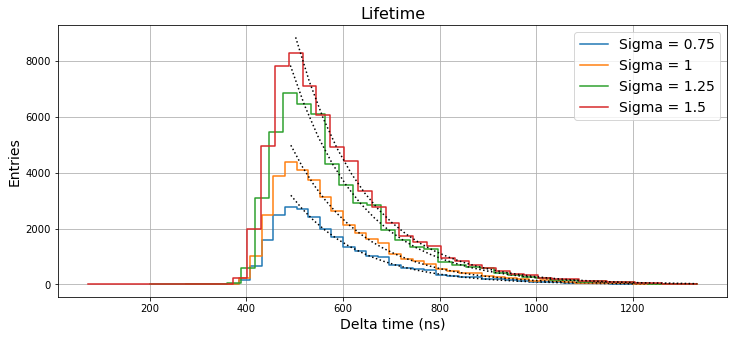

Wall time: 1.01 s


In [23]:
%%time

def myExp(x,a,tau):
    return a*np.exp(-x/tau)

listaSigme = []
listaLifetime = []
listaErrLifetime = []
nuovalistachi2 = []





def calcolaLifetime(nsigma, altezza, numBins):
    
    ADC1_min = lista_popt[3][0][1] - nsigma*lista_popt[3][0][2]
    ADC1_max = lista_popt[3][0][1] + nsigma*lista_popt[3][0][2]
    ADC2_min = lista_popt[3][1][1] - nsigma*lista_popt[3][1][2]
    ADC2_max = lista_popt[3][1][1] + nsigma*lista_popt[3][1][2]

    """
    listaTempi = []
    for i in range(len(time)):
        if (ADC1[i] >= ADC1_min) & (ADC1[i] <= ADC1_max) & \
           (ADC2[i] >= ADC2_min) & (ADC2[i] <= ADC2_max) :
               
               listaTempi.append(np.abs(time1[i] - time2[i]))
               
              
    listaTempi = np.array(listaTempi) 
    """
    
    cond = (ADC1 >= ADC1_min) & (ADC1 <= ADC1_max) & \
           (ADC2 >= ADC2_min) & (ADC2 <= ADC2_max)
    
    listaTempi = np.abs(time1[cond] - time2[cond])

      


    
    h, bins = np.histogram(listaTempi, bins=numBins)
    binc = bins[:-1] + bins[1] - bins[0]
    
    plt.plot(binc, h, ds = "steps-mid", label = f"Sigma = {nsigma}")
    
    
    # fitto con un exp
    condizione = binc > 480
    xVect = binc[condizione]
    yVect = h[condizione]
    
    popt, pcov = curve_fit(myExp, xVect, yVect, sigma = np.sqrt(yVect),
                           p0 = [altezza, 1.41920784e+02], absolute_sigma = True)
    
    plt.plot(xVect, myExp(xVect,*popt), ls = ":", c="k")
    

    print(f"Sigma: {nsigma} - Vita media: {popt[1]} ± {np.sqrt(pcov[1,1])}")

    listaSigme.append(nsigma)
    listaLifetime.append(popt[1])  
    listaErrLifetime.append(np.sqrt(pcov[1,1]))   
    
    # calcolo i chi2
    tmpchi2 = np.sum(( (yVect - myExp(xVect,*popt)) / np.sqrt(yVect)  )**2)/(len(yVect)-2)
    nuovalistachi2.append(tmpchi2)
   
    
   
    
# Calcolo le lifetime  
    
   
plt.figure(figsize=(12,5))
plt.title(f"Lifetime", fontsize=16)


calcolaLifetime(.75, 1.59507942e+05, 45)
calcolaLifetime(1, 1.59507942e+05, 45)
calcolaLifetime(1.25, 1.59507942e+05, 40)
calcolaLifetime(1.5, 1.59507942e+05, 45)

plt.xlabel("Delta time (ns)", fontsize=14)
plt.ylabel("Entries", fontsize=14)
plt.legend(fontsize=14)
plt.grid()
if Export:
    plt.savefig(r'../RELAZIONE/FIGURE/lifetime.eps', format='eps')
plt.show()



listaSigme = np.array(listaSigme)
listaLifetime = np.array(listaLifetime)
listaErrLifetime = np.array(listaErrLifetime)
# Testo la compatibilità con 141
Zvect = np.abs(141-listaLifetime)/listaErrLifetime

### Senza taglio

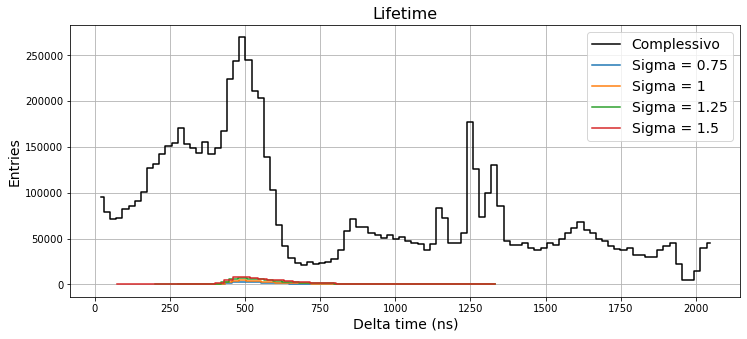

Wall time: 1.61 s


In [24]:
%%time

def calcolaLifetimebrutta(nsigma, altezza, numBins, primo=False):
    
    ADC1_min = lista_popt[3][0][1] - nsigma*lista_popt[3][0][2]
    ADC1_max = lista_popt[3][0][1] + nsigma*lista_popt[3][0][2]
    ADC2_min = lista_popt[3][1][1] - nsigma*lista_popt[3][1][2]
    ADC2_max = lista_popt[3][1][1] + nsigma*lista_popt[3][1][2]

    listaTempi = []
    listaTempiBrutto = []
    
            
    cond = (ADC1 >= ADC1_min) & (ADC1 <= ADC1_max) & \
           (ADC2 >= ADC2_min) & (ADC2 <= ADC2_max)
    
    listaTempi = np.abs(time1[cond] - time2[cond])
               
    if primo:
        listaTempiBrutto = np.abs(time1 - time2)
               

        hb, binsb = np.histogram(listaTempiBrutto, bins=100)
        bincb = binsb[:-1] + binsb[1] - binsb[0]
        plt.plot(bincb, hb, ds = "steps-mid", label = f"Complessivo", c="k")
    
    


    h, bins = np.histogram(listaTempi, bins=numBins)
    binc = bins[:-1] + bins[1] - bins[0]
    
    plt.plot(binc, h, ds = "steps-mid", label = f"Sigma = {nsigma}")
    
   
    
# Calcolo le lifetime  
    
   
plt.figure(figsize=(12,5))
plt.title(f"Lifetime", fontsize=16)


calcolaLifetimebrutta(.75, 1.59507942e+05, 45, True)
calcolaLifetimebrutta(1, 1.59507942e+05, 45)
calcolaLifetimebrutta(1.25, 1.59507942e+05, 40)
calcolaLifetimebrutta(1.5, 1.59507942e+05, 45)

plt.xlabel("Delta time (ns)", fontsize=14)
plt.ylabel("Entries", fontsize=14)
plt.legend(fontsize=14)
plt.grid()



if Export:
    plt.savefig(r'../RELAZIONE/FIGURE/lifetime-brutto.eps', format='eps')
plt.show()

Agli istogrammi appena visti è stato anche sovrapposto l'istogramma relativo a tutti i dati a disposizione: i dati di interesse, che hanno permesso di calcolare un tempo coerente con quello atteso praticamente non si vedono, sembrano una minima parte. L'istogramma logaritmico consente di vederli meglio.

Non si può che restare meravigliati dalla potenza della tecnica delle coincidenza, che ha permesso di selezionare una piccolissima frazione degli 8 milioni di eventi a disposizione, ma che hanno consentito di misurare il tempo di vita.

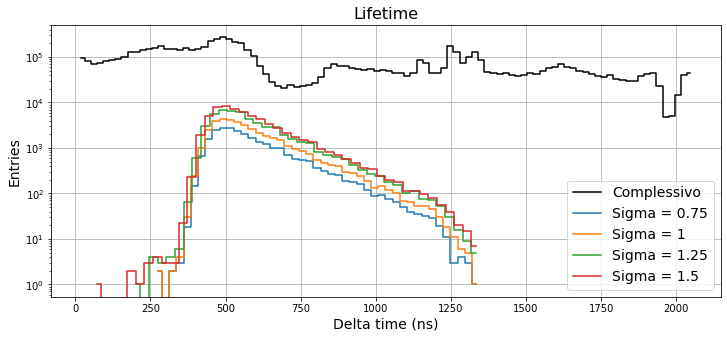

Wall time: 1.68 s


In [25]:
%%time

def calcolaLifetimebrutta(nsigma, altezza, numBins, primo=False):
    
    ADC1_min = lista_popt[3][0][1] - nsigma*lista_popt[3][0][2]
    ADC1_max = lista_popt[3][0][1] + nsigma*lista_popt[3][0][2]
    ADC2_min = lista_popt[3][1][1] - nsigma*lista_popt[3][1][2]
    ADC2_max = lista_popt[3][1][1] + nsigma*lista_popt[3][1][2]

    listaTempi = []
    listaTempiBrutto = []
    
            
    cond = (ADC1 >= ADC1_min) & (ADC1 <= ADC1_max) & \
           (ADC2 >= ADC2_min) & (ADC2 <= ADC2_max)
    
    listaTempi = np.abs(time1[cond] - time2[cond])
               
    if primo:
        listaTempiBrutto = np.abs(time1 - time2)
               

        hb, binsb = np.histogram(listaTempiBrutto, bins=100)
        bincb = binsb[:-1] + binsb[1] - binsb[0]
        plt.plot(bincb, hb, ds = "steps-mid", label = f"Complessivo", c="k")
    
    


    h, bins = np.histogram(listaTempi, bins=numBins)
    binc = bins[:-1] + bins[1] - bins[0]
    
    plt.plot(binc, h, ds = "steps-mid", label = f"Sigma = {nsigma}")
    
   
    
# Calcolo le lifetime  
    
   
plt.figure(figsize=(12,5))
plt.title(f"Lifetime", fontsize=16)


calcolaLifetimebrutta(.75, 1.59507942e+05, 45, True)
calcolaLifetimebrutta(1, 1.59507942e+05, 45)
calcolaLifetimebrutta(1.25, 1.59507942e+05, 40)
calcolaLifetimebrutta(1.5, 1.59507942e+05, 45)

plt.xlabel("Delta time (ns)", fontsize=14)
plt.ylabel("Entries", fontsize=14)
plt.legend(fontsize=14)
plt.yscale("log")
plt.grid()



if Export:
    plt.savefig(r'../RELAZIONE/FIGURE/lifetime-brutto.eps', format='eps')
plt.show()

# Appendice A: l'importanza di guardare i dati

[Questi dati](https://www.autodesk.com/research/publications/same-stats-different-graphs) hanno la particolarità di avere alcuni indici statistici uguali fino alla seconda cifra decimale (media x/y, std x/y e indice di correlazione di Pearson). Questo semplice esempio vuole mettere in luce l'importanza di guardare i dati, non limitarsi a farseli riassumere da qualche indice statistico

In [26]:
dat = np.loadtxt(".\DatasaurusDozen-wide.tsv", dtype = float, delimiter = "\t", skiprows = 2)
dat.shape


(142, 26)

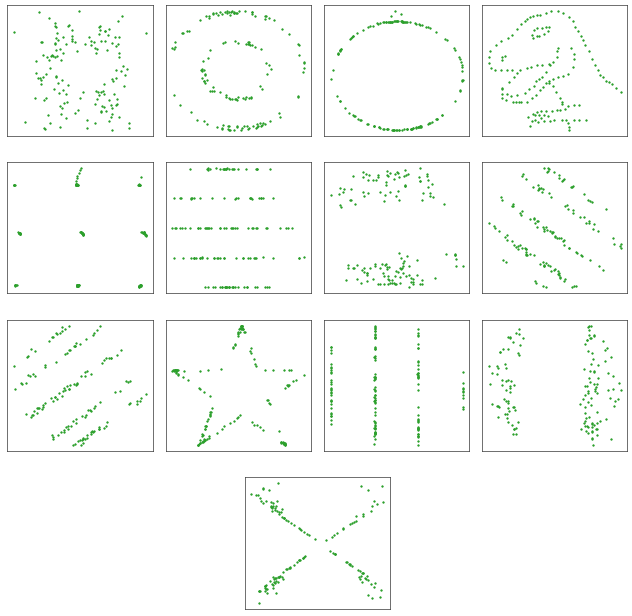

In [27]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16,16), dpi = 50) 
gs=gridspec.GridSpec(nrows=4, ncols=8, hspace=.2, wspace=.2)

ax = []
for i in range(12): pass
ax.append(fig.add_subplot(gs[0,0:2]))
ax.append(fig.add_subplot(gs[0,2:4]))
ax.append(fig.add_subplot(gs[0,4:6]))
ax.append(fig.add_subplot(gs[0,6:8]))

ax.append(fig.add_subplot(gs[1,0:2]))
ax.append(fig.add_subplot(gs[1,2:4]))
ax.append(fig.add_subplot(gs[1,4:6]))
ax.append(fig.add_subplot(gs[1,6:8]))

ax.append(fig.add_subplot(gs[2,0:2]))
ax.append(fig.add_subplot(gs[2,2:4]))
ax.append(fig.add_subplot(gs[2,4:6]))
ax.append(fig.add_subplot(gs[2,6:8]))

ax.append(fig.add_subplot(gs[3,3:5]))




ss = dat.shape
for i in range(len(ax)):
    ax[i].scatter(dat[:,2*i], dat[:,2*i+1], s = 5, c = "tab:green")
    
for i in ax:
    i.set_xticks([])
    i.set_yticks([])
    
plt.show()
    


In [28]:
from scipy.stats import pearsonr

for i in range(13):
    print(f"Dataset: {i}\t mean x: {np.mean(dat[:,2*i]):.4f}\t mean y: {np.mean(dat[:,2*i+1]):.4f}\t std x: {np.std(dat[:,2*i]):.4f}\t std y: {np.std(dat[:,2*i+1]):.4f}\t coor Pearson: {pearsonr(dat[:,2*i], dat[:,2*i+1])}") 

Dataset: 0	 mean x: 54.2661	 mean y: 47.8347	 std x: 16.7107	 std y: 26.8447	 coor Pearson: (-0.0641283521547448, 0.44832881989437273)
Dataset: 1	 mean x: 54.2687	 mean y: 47.8308	 std x: 16.7101	 std y: 26.8407	 coor Pearson: (-0.06858639425794844, 0.417346725544837)
Dataset: 2	 mean x: 54.2673	 mean y: 47.8377	 std x: 16.7009	 std y: 26.8350	 coor Pearson: (-0.06834335645012025, 0.419002902754496)
Dataset: 3	 mean x: 54.2633	 mean y: 47.8323	 std x: 16.7060	 std y: 26.8404	 coor Pearson: (-0.06447185270095164, 0.44589659802470616)
Dataset: 4	 mean x: 54.2603	 mean y: 47.8398	 std x: 16.7086	 std y: 26.8352	 coor Pearson: (-0.06034144199353861, 0.4756315608671553)
Dataset: 5	 mean x: 54.2614	 mean y: 47.8303	 std x: 16.7068	 std y: 26.8448	 coor Pearson: (-0.06171483795667776, 0.4656268147329629)
Dataset: 6	 mean x: 54.2688	 mean y: 47.8355	 std x: 16.7076	 std y: 26.8450	 coor Pearson: (-0.06850422050586688, 0.41790626967402816)
Dataset: 7	 mean x: 54.2678	 mean y: 47.8359	 std x: 16

# Appendice B: il problema della funzione spigolosa
Talvolta, per esempio quando si effettua il fit gaussiano di un picco, può accadere di avere pochi punti a disposizione. Ricalcando quanto descritto nel [tutorial del prof. Mascagna](https://vmascagn.web.cern.ch/vmascagn/LABO_2020/tutorial_spettroscopia_1_ed2021.html), generiamo un esempio di dati e vediamo come approcciare il problema

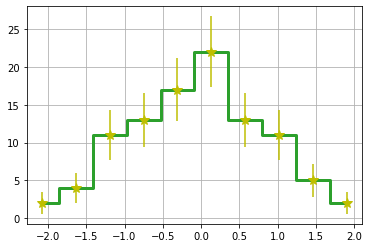

In [29]:
dati_casuali = np.random.normal(0,1,100)

h, bins = np.histogram(dati_casuali, bins = 10)
binc = bins[:-1] + (bins[1] - bins[0])/2

fig, ax = plt.subplots()

ax.plot(binc, h, ds = "steps-mid", c = "tab:green", lw = 3)
ax.errorbar(binc, h, yerr = np.sqrt(h), fmt = "*y", ms = 10)
ax.grid()

plt.show()

Proviamo ora ad eseguire il fit con la gaussiana

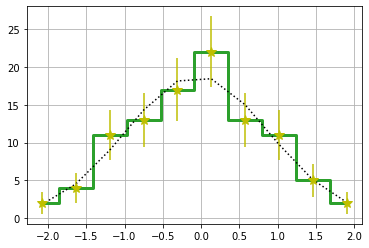

In [30]:
popt, pcov = curve_fit(gauss, binc, h, sigma = np.sqrt(h))

fig, ax = plt.subplots()

ax.plot(binc, h, ds = "steps-mid", c = "tab:green", lw = 3)
ax.errorbar(binc, h, yerr = np.sqrt(h), fmt = "*y", ms = 10)
ax.plot(binc, gauss(binc, *popt), ls = ":", c = "k")
ax.grid()

plt.show()

Per risolvere il problema creiamo un vettore "più denso", che abbia i medesimi estremi, ma con più punti in mezzo, in modo tale che la funzione venga disegnata più smussata. Tale problema in linea teorica l'abbiamo già incontrato con la retta di calibrazione ma, trattandosi di una retta, l'avere pochi punti in mezzo non ha alcuna rilevanza: bastano infatti due punti per definire una retta nello spazio.

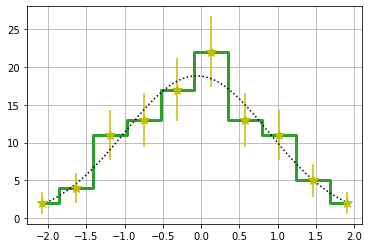

In [31]:
xDenso = np.linspace(binc[0], binc[-1], num = 1000)


fig, ax = plt.subplots()

ax.plot(binc, h, ds = "steps-mid", c = "tab:green", lw = 3)
ax.errorbar(binc, h, yerr = np.sqrt(h), fmt = "*y", ms = 10)
ax.plot(xDenso, gauss(xDenso, *popt), ls = ":", c = "k")
ax.grid()

plt.show()